# Forecasting Danube Water Levels

## Introduction
Hi! 
Welcome to the water level forecasting benchmark exercise for the Danube's measuring station "Kienstock" at km 2015.21. 
There's an official [government forecast](https://www.noel.gv.at/wasserstand/#/de/Messstellen/Details/207357/WasserstandPrognose/48Stunden) which we aim to beat with an LSTM model. 
enjoy ;-)

## Let's first make sure we have the right versions of Tensorflow and Keras

In [ ]:
!pip install --upgrade keras-applications keras-preprocessing setuptools tensorflow==1.14.0 keras==2.2.5

In [ ]:
import tensorflow
if not tensorflow.__version__ == '1.14.0':
    print(tensorflow.__version__)
    raise ValueError('please upgrade to TensorFlow 1.14.0, or restart your Kernel (Kernel->Restart & Clear Output)')

import keras
if not keras.__version__ == '2.2.5':
    print(keras.__version__)
    raise ValueError('please upgrade to Keras 2.2.5, or restart your Kernel (Kernel->Restart & Clear Output)')

OK, now let's get the Keras elements we'll use.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.callbacks import Callback

## Now let's load all other dependencies

In [1]:
import numpy as np # linear algebra
from numpy import concatenate

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import read_csv
from pandas import DataFrame

import matplotlib.pyplot as plt # plotting
from mpl_toolkits.mplot3d import Axes3D

import sklearn # ML libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

import os # accessing directory structure
# import sys # maybe we need this to access the file system

%matplotlib inline

Let's see if we have acces to the data file

In [2]:
!rm * # clear current working directory

In [3]:
# !wget https://emelt2.ocloud.de/index.php/s/aSS6kGMeTGXP0GW/download
!wget https://raw.githubusercontent.com/spegelm/fdwl/master/danube-waterlevel-Kienstock_2002-2019.csv
!mv download danube-waterlevel-Kienstock_2002-2019.csv

--2020-01-15 16:24:21--  https://raw.githubusercontent.com/spegelm/fdwl/master/danube-waterlevel-Kienstock_2002-2019.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.56.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.56.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190666 (186K) [text/plain]
Saving to: ‘danube-waterlevel-Kienstock_2002-2019.csv’

100%[======================================>] 190,666     --.-K/s   in 0.02s   

2020-01-15 16:24:21 (11.4 MB/s) - ‘danube-waterlevel-Kienstock_2002-2019.csv’ saved [190666/190666]

mv: cannot stat ‘download’: No such file or directory


There is 1 csv file in the current version of the dataset:


In [4]:
# check what files we have got
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./danube-waterlevel-Kienstock_2002-2019.csv


Now we're ready to read in the data and use the plotting functions to visualize the data.

In [6]:
nRowsRead = 1200 # specify 'None' if want to read whole file
# danube-waterlevel-Kienstock_2002-2019.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('danube-waterlevel-Kienstock_2002-2019.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'danube-waterlevel-Kienstock_2002-2019.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1200 rows and 4 columns


Let's take a quick look at what the data looks like:

In [9]:
# df1.head(5)

Let's continue with max values only. We are looking for flood maxima afte all, and min and mean are highly correlated.

In [10]:
df1 = df1.loc[:, ["date", "max"]]
df1.head(5)

,date,max
0,01.01.2002 00:00,417
1,02.01.2002 00:00,369
2,03.01.2002 00:00,329
3,04.01.2002 00:00,298
4,05.01.2002 00:00,283


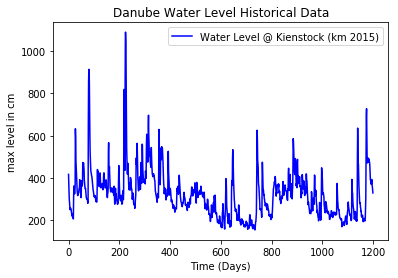

In [11]:
df1_plot = df1.iloc[:,1:2].values.astype(float)
# Visualising the Data
plt.plot(df1_plot, color = 'blue', label = 'Water Level @ Kienstock (km 2015)')
plt.title('Danube Water Level Historical Data')
plt.xlabel('Time (Days)')
plt.ylabel('max level in cm')
plt.legend()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5d3d2f908>]],
      dtype=object)

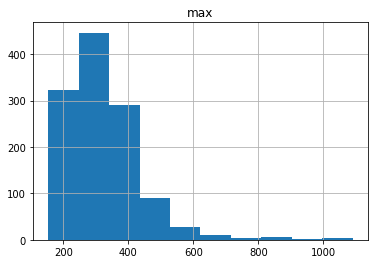

In [12]:
df1.hist()

Let's see if we have any missing data

In [13]:
missing_data = df1.isnull()

In [14]:
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("") 

date
False    1200
Name: date, dtype: int64

max
False    1200
Name: max, dtype: int64



In case there are any "Trues" we replace the NaNs with the mean of the neighbors

In [15]:
for i in range (0, len(df1)):
    if missing_data.iloc[i,1]:
        df1.iloc[i,1] = (df1.iloc[i-1,1] + df1.iloc[i+1,1]) / 2
        print(i, df1.iloc[i,1])

Next we have to prepare the data sets

In [82]:
# defining some parameters
batchsize = 1 # needed for LSTM
timesteps = 3 # window size
test_share = 0.1 # test set size

In [83]:
def get_set_length(length, batch, timesteps):
    # substract test_percent to be excluded from training, reserved for testset
    modulo = int((length - 2 * timesteps) % batch)
    return int(length - modulo)

In [84]:
# setting data set lengths
length_tot = len(df1)
print(length_tot)
length_train = get_set_length((length_tot * (1 - test_share)), batchsize, timesteps)
print(length_train)
length_test = get_set_length((length_tot - length_train), batchsize, timesteps)
print(length_test)

1200
1080
120


In [85]:
# creating data sets with feature scaling between 0 and 1.

sc = MinMaxScaler(feature_range = (0, 1))
total_set = df1.iloc[:,1:2].values
total_set_scaled = sc.fit_transform(np.float64(total_set))

training_set_scaled = total_set_scaled[0:length_train]
print(training_set_scaled.shape)
# print(training_set_scaled[0:3])

test_set = total_set[length_train:length_train+length_test]
print(test_set.shape)
# print(test_set[0:3])

test_set_scaled = total_set_scaled[length_train:length_train+length_test]
print(test_set_scaled.shape)
# print(test_set_scaled[0:3])

(1080, 1)
(120, 1)
(120, 1)


Now let's set a baseline forecast with linear regression

In [86]:
# Creating data structures for linear regression with n timesteps
lr_train_windows = []
for i in range(timesteps, length_train): 
    lr_train_windows.append(training_set_scaled[i-timesteps:i,0])

print(np.array(lr_train_windows).shape)
print(lr_train_windows[0:2])

lr_test_windows = []
for i in range(timesteps, length_test): 
    lr_test_windows.append(test_set_scaled[i-timesteps:i,0])

print(np.array(lr_test_windows).shape)
print(lr_test_windows[0:3])

(1077, 3)
[array([0.28098291, 0.22970085, 0.18696581]), array([0.22970085, 0.18696581, 0.15384615])]
(117, 3)
[array([0.02884615, 0.03632479, 0.03846154]), array([0.03632479, 0.03846154, 0.03525641]), array([0.03846154, 0.03525641, 0.0267094 ])]


In [87]:
# convert data structures to np.arrays for linear regression
x_train = np.asarray(lr_train_windows)
y_train = training_set_scaled[timesteps:length_train]
print(x_train.shape)
# print(x_train[:3])
print(y_train.shape)
# print(y_train[:3])

(1077, 3)
(1077, 1)


In [88]:
# do the fit
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
# the regression coefficients
print ('Coefficients: ', lr_model.coef_)

Coefficients:  [[ 0.2370081  -0.67136031  1.3581916 ]]


In [89]:
# get predicted data on the training set (for the visualization)
y_train_pred = lr_model.predict(x_train) 

# inverse transform (reverse feature scaling)
y_train_pred_unscaled = sc.inverse_transform(y_train_pred)
print(y_train_pred_unscaled.shape)

(1077, 1)


In [92]:
# convert test data structures to numpy arrays
x_test = np.asarray(lr_test_windows)
y_test_orig = test_set[timesteps:length_test]
print(x_test.shape)
print(y_test_orig.shape)

(117, 3)
(117, 1)


In [93]:
# get predicted data on the test set
y_test_pred = lr_model.predict(x_test)

# inverse transform (reverse feature scaling)
y_test_pred_unscaled = sc.inverse_transform(y_test_pred)

print(y_test_pred_unscaled.shape)
# print(y_test_pred_unscaled[0:3])

(117, 1)


In [104]:
# calculate mean squared error on the test set predictions
lr_test_residuals = y_test_pred_unscaled - y_test_orig
lr_rmse = np.sqrt(np.sum(np.power(lr_test_residuals,2)) / len(lr_test_residuals))
print('LinReg RMSE = %.2f' % lr_rmse)

LinReg RMSE = 39.68


In [105]:
# calculate mean squared error on the trivial predictions
triv_residuals = y_test_orig[1:] - y_test_orig[:-1]
triv_rmse = np.sqrt(np.sum(np.power(triv_residuals,2)) / len(triv_residuals))
print('Trivial RMSE = %.2f' % triv_rmse)

Trivial RMSE = 48.13


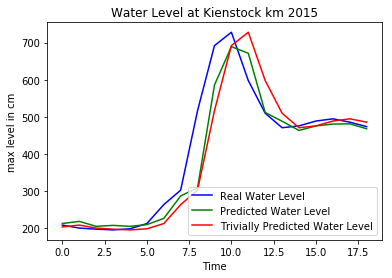

In [101]:
# Visualising the results
plt.plot(y_test_orig[81:100], color = 'blue', label = 'Real Water Level')
plt.plot(y_test_pred_unscaled[81:100], color = 'green', label = 'Predicted Water Level')
plt.plot(y_test_orig[80:99], color = 'red', label = 'Trivially Predicted Water Level')
plt.title('Water Level at Kienstock km 2015')
plt.xlabel('Time')
plt.ylabel('max level in cm')
plt.legend()
plt.show()